# Progetto esame Analisi Statistica dei Dati Sperimentali

Lo scopo del seguente progetto è fare un'analisi statistica dei dati riguardanti il transito dell'esopianeta [HD 189733b](https://exoplanet.eu/catalog/hd_189733_ab--307/) davanti alla sua *host star* [HD 189733](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=HD189733&submit=SIMBAD+search).

I transiti degli esopianeti, vale a dire il passaggio del pianeta davanti la stella (la situazione opposta è l'eclissi), sono uno dei principali metodi di indagine delle caratteristiche fisiche e chimiche degli stessi, e note le caratteristiche della stella (massa, raggio, tipo spettrale), si possono ricavare massa e raggio del pianeta, nonché i parametri orbitali del sistema.

La quantità misurata è il flusso $F$, cioè la quantità di energia ricevuta dalla stella che attraversa un'unità di area perpendicolare alla direzione della luce, per unità di tempo, su tutte le lugnhezze d'onda. Questa misura viene effettua per un tempo $t$ maggiore della durata del transito, così da avere informazioni sul flusso normalmente ricevuto dalla stella e poter chiaramente osservare il picco negativo corrispondente all'oscuramento di parte della stella a causa del passaggio del pianeta.

In particolare, il flusso viene fornito come **flusso relativo** tra la *target star* e una stella di riferimento; ciò è dovuto al fatto che il flusso dipende (anche) dalla distanza tra l'astro e l'osservatore. Per questo tipo di analisi, tuttavia, questo non risulta essere un problema, in quanto si è interessati a studiare la variazione del flusso e il cui livello standard può in ogni caso considerarsi come normalizzato ad 1.

Graficando l'andamento temporale del flusso si costruisce la **curva di luce** che permette la visualizzazione del fenomeno e il confronto con un modello teorico.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
import batman

In [2]:
file_fluxes = 'curva_luce_differenziale.txt'
fluxes = np.loadtxt(file_fluxes, skiprows=1)

In [3]:
df = pd.DataFrame(fluxes)
df.columns = ('jd', 'flux_target', 'flux_comp', 'flux_rel')
df['delta_jd'] = df.loc[:, 'jd'] - df.at[0, 'jd'] #tempo è espresso in JD (Julian Day)
df['time'] = df.loc[:, 'delta_jd']*86400 #per transformare l'intervallo di tempo in secondi va moltiplicato per 86400
df = df.drop('flux_target', axis=1)
df = df.drop('flux_comp', axis=1)

df

,jd,flux_rel,delta_jd,time
0,2.460957e+06,0.994835,0.000000,0.000000
1,2.460957e+06,1.015616,0.000242,20.941991
2,2.460957e+06,1.011788,0.000485,41.899994
3,2.460957e+06,1.005392,0.000727,62.854980
4,2.460957e+06,1.020716,0.000971,83.863999
...,...,...,...,...
480,2.460957e+06,1.013293,0.120732,10431.207995
481,2.460957e+06,1.022012,0.120975,10452.199996
482,2.460957e+06,1.059279,0.121218,10473.217987
483,2.460957e+06,1.020086,0.121460,10494.158971


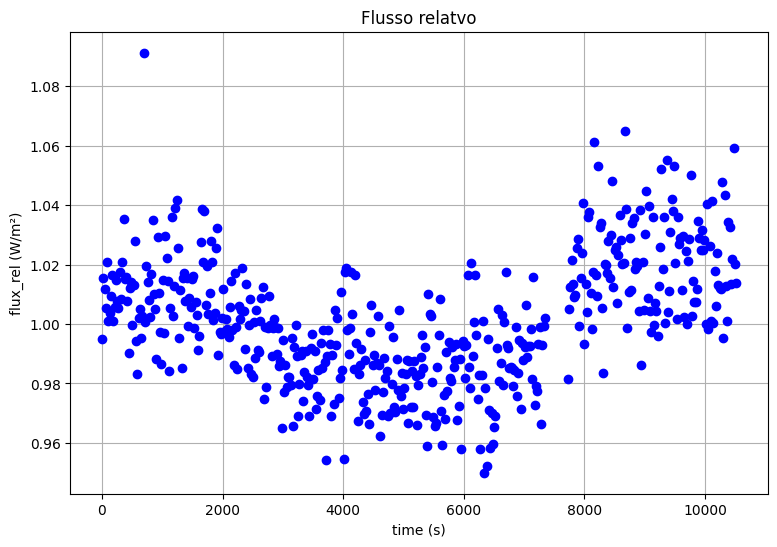

In [4]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.grid()
ax.set_axisbelow(True)
ax.scatter(df['time'], df['flux_rel'], c='b')
ax.set_title('Flusso relatvo')
ax.set_xlabel('time (s)')
ax.set_ylabel('flux_rel (W/m²)')
plt.show()

## Visualizzazione dei punti e rimozione effetti sistematici

Si vede subito che i punti, pur presentando un chiaro andamento, sono molto dispersi attorno ai valori medi; questo è dovuto in generale alle condizioni sperimentali totalmente avverse (inquinamento atmosferico e luminoso, umidità nell'aria, traffico aereo, luce lunare), che quindi risultano in misure scarsamente preciso, indipendentemente dalla loro accuratezza.

In prima analisi notiamo la presenza di un punto chiaramente fuori scala rispetto agli altri, con $F > 1.08$, che quindi andiamo ad eliminare.

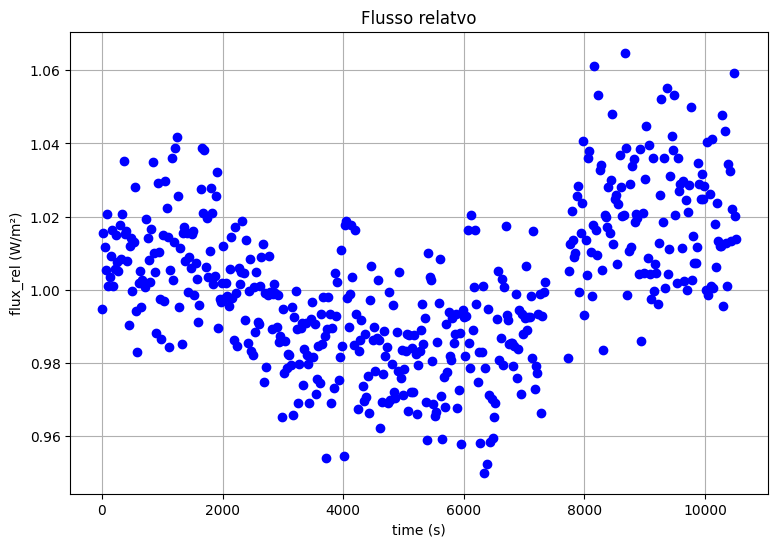

In [5]:
plane = df.loc[df['flux_rel'] > 1.08].index
df = df.drop(plane)

fig, ax = plt.subplots(figsize=(9, 6))
ax.grid()
ax.set_axisbelow(True)
ax.scatter(df['time'], df['flux_rel'], c='b')
ax.set_title('Flusso relatvo')
ax.set_xlabel('time (s)')
ax.set_ylabel('flux_rel (W/m²)')
plt.show()

Il secondo problema più evidente è come i punti, al di là del picco centrale dovuto al transito, mostrano una crescita lineare. Questo trend va rimosso, giacchè rappresenta sostanzialmente un errore sistematico; non vi è motivo per cui il flusso luminoso dovrebbe aumentare nel tempo, specie su tempi così brevi, e inoltre i modelli matematici di transito prevedono un flusso costante prima e dopo il transito.

Per la rimozione del trend, essendo questa una crescita dipendente dal tempo e non costante, si è scelto di fare un *fit* lineare, ma considerando soltanto i primi 10 e gli ultimi 10 punti, per evitare di andare a rimuovere anche l'andamento tipico della curva di luce.

Questi punti, infatti, dovrebbero trovarsi sulla stessa ordinata (entro qualche $\sigma$).

In [6]:
def line(x, m, b):
    return m*x + b

flux10 = df.loc[:, 'flux_rel'].to_numpy()
flux10 = np.concatenate([flux10[:10], flux10[-10:]])

time10 = df.loc[:, 'time'].to_numpy()
time10 = np.concatenate([time10[:10], time10[-10:]])

sigma_flux10 = np.ones_like(flux10)
leastsquares10 = LeastSquares(time10, flux10, sigma_flux10, line)

fit10 = Minuit(leastsquares10, m=0.0, b=0.0)
fit10.migrad()
fit10.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.003291 (χ²/ndof = 0.0)   │              Nfcn = 45               │
│ EDM = 1.94e-25 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │     0     │  0.04e-3  │            │            │         │         │       │
│ 1 │ b    │   1.01    │   0.32    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────┐
│   │          m          b │
├───┼───────────────────────┤
│ m │   1.88e-09 -9.8596e-6 │
│ b │ -9.8596e-6      0.102 │
└───┴───────────────────────┘

In [7]:
m = fit10.values['m']
b = fit10.values['b']
m_err = fit10.errors['m']
b_err = fit10.errors['b']

print(f'parametri fit:\n{m:5e} +- {m_err:5e}\n{b:5e} +- {b_err:5e}')

parametri fit:
1.674891e-06 +- 4.330508e-05
1.007798e+00 +- 3.191198e-01


In [8]:
df['flux_fit'] = df.loc[:, 'flux_rel'] - m*df.loc[:, 'time']

df

,jd,flux_rel,delta_jd,time,flux_fit
0,2.460957e+06,0.994835,0.000000,0.000000,0.994835
1,2.460957e+06,1.015616,0.000242,20.941991,1.015581
2,2.460957e+06,1.011788,0.000485,41.899994,1.011718
3,2.460957e+06,1.005392,0.000727,62.854980,1.005287
4,2.460957e+06,1.020716,0.000971,83.863999,1.020575
...,...,...,...,...,...
480,2.460957e+06,1.013293,0.120732,10431.207995,0.995821
481,2.460957e+06,1.022012,0.120975,10452.199996,1.004506
482,2.460957e+06,1.059279,0.121218,10473.217987,1.041738
483,2.460957e+06,1.020086,0.121460,10494.158971,1.002510


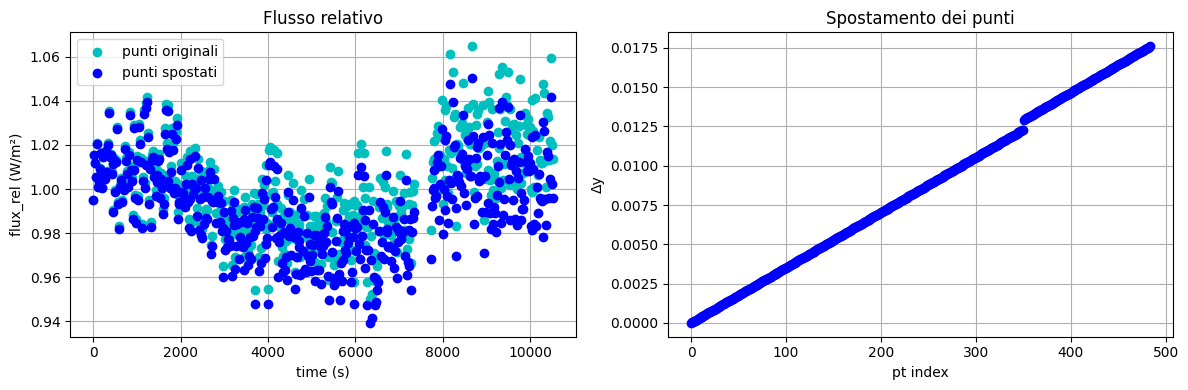

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.grid()
ax1.set_axisbelow(True)
ax1.scatter(df['time'], df['flux_rel'], c='c', label='punti originali')
ax1.scatter(df['time'], df['flux_fit'], c='b', label='punti spostati')
ax1.legend()
ax1.set_title('Flusso relativo')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('flux_rel (W/m²)')

ax2.grid()
ax2.set_axisbelow(True)
ax2.scatter(df.index, df['flux_rel']-df['flux_fit'], c='b')
ax2.set_title('Spostamento dei punti')
ax2.set_xlabel('pt index')
ax2.set_ylabel('Δy')

plt.tight_layout()
plt.show()

Si vede che il trend non è stato del tutto rimosso, ma è comunque presente un grosso miglioramento, sufficiente per l'analisi al primo ordine che stiamo andando a fare.

I dati inoltre presentano un'interruzione: probabilmente il telescopio ha cessato di funzionare per qualche tempo, o l'astro è stato temporaneamente oscurato.

## Curva di luce: modello trapezoidale

Andiamo quindi a scrivere un primo modello matematico per la curva di luce, mediante una funzione definita a tratti, che ci dica la diminuzione del flusso durante le varie fasi del transito.

Chiamiamo:
* $F_0$ livello normale del flusso
* $F_1$ minimo livello del flusso
* $\Delta F$ profondità del flusso ($F_a - F_d$ in figura)
* $t_0$ tempo del minimo, centro transito ($t_d$ in figura)
* $T$ durata totale del transito ($t_f - t_b$)
* $\tau = t_2 - t_1 = t_4 - t_3$, durata in-out ($t_c- t_b = t_f - t_e$)

Dati i quattro punti di contatto, possiamo scrivere:

$\displaystyle \begin{cases}
    t_1 = t_0 - \frac{T}{2}\\
    t_2 = t_1 + \tau\\
    t_3 = t_2 + (T - 2\tau)\\
    t_4 = t_0 + \frac{T}{2}\\
    \end{cases}$

E dunque otteniamo la seguente funzione:

$\displaystyle F(t)=\begin{cases}
    F_0 & t \leq t_1 \land t \geq t_4 & \text{(pre- e post-transito)} \\
    F_0 - \Delta F \left(\frac{t - t_1}{\tau}\right) & t_1 < t \leq t_2 & \text{(ingresso)}\\
    F_0 - \Delta F & t_2 < t \leq t_3 & \text{(eclissi)}\\
    F_0 + \Delta F \left(1 - \frac{t - t_3}{\tau}\right) & t_3 < t < t_4 & \text{(uscita)}\\
    \end{cases}$

![Transit method](transit_method.png)
[IOP](https://spark.iop.org/)

In [10]:
def piecewise(t, F0, deltaF, t0, T, tau):
    t1, t2, t3, t4 = t0 - 0.5*T, t0 - 0.5*T + tau, t0 + 0.5*T - tau, t0 + 0.5*T
    return np.piecewise(t,
        [
            (t <= t1) | (t >= t4),
            (t > t1) & (t <= t2),
            (t > t2) & (t <= t3),
            (t > t3) & (t < t4)
        ],
        [
            lambda t: F0,
            lambda t: F0 - deltaF * (t - t1) / tau,
            lambda t: F0 - deltaF,
            lambda t: F0 - deltaF + deltaF * (t - t3) / tau
        ])

Non avendo gli errori per i singoli punti, li dovremo ricavare *fit*, calcolando i residui, cioè la distanza di ogni punto sperimentale $\hat{y}_i$ dal valore della funzione $y_i = F(t)$, quindi $\varepsilon_i = y_i - \hat{y}_i$.

Considerando i punti come variabili gaussiane distribuite attorno al valore vero, l'errore risulta essere la deviazione standard dei residui.

## Fit con modello trapezoidale

Per poter effettuare un *fit*, è necessario fornire a Minuit un *first guess* per la stima di ogni parametro; pertanto, per avere un'idea approssimata dei loro possibili valori, facciamo una media ogni quattro punti (485/4=121).

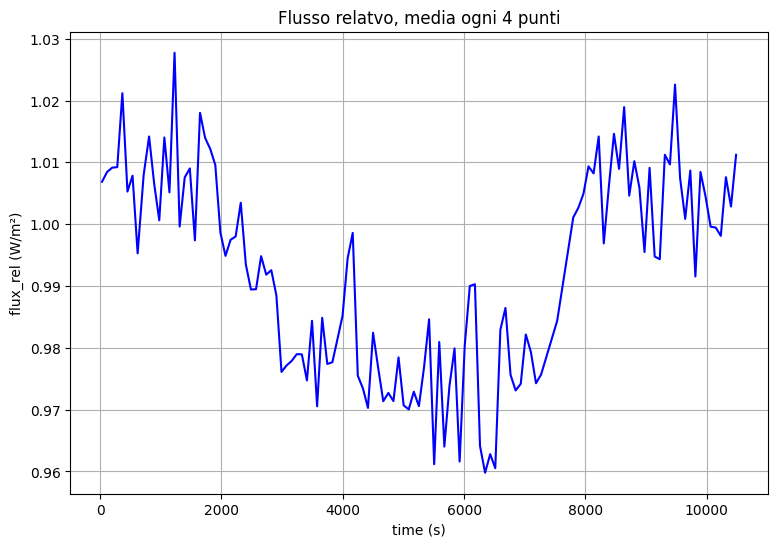

In [11]:
t4 = np.mean(np.reshape(df['time'], (121, 4)), axis=1)
flux4 = np.mean(np.reshape(df['flux_fit'], (121, 4)), axis=1)

fig, ax = plt.subplots(figsize=(9, 6))
ax.grid()
ax.set_axisbelow(True)
ax.plot(t4, flux4, c='b')
ax.set_title('Flusso relatvo, media ogni 4 punti')
ax.set_xlabel('time (s)')
ax.set_ylabel('flux_rel (W/m²)')
plt.show()

In [12]:
#first guesses
#F0, deltaF, t0, T, tau
guesses = [1.005, 0.030, 5000, 6000, 1000]

In [13]:
time = df['time']
flux = df['flux_fit']
sigmaflux = np.ones_like(flux)

lsquaresflux = LeastSquares(time, flux, sigmaflux, piecewise)
mF = Minuit(lsquaresflux,
            F0=guesses[0], deltaF=guesses[1], t0=guesses[2], T=guesses[3], tau=guesses[4])
mF.migrad()
mF.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1002 (χ²/ndof = 0.0)     │              Nfcn = 242              │
│ EDM = 4.43e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ F0     │   1.01    │   0.07    │            │            │         │         │       │
│ 1 │ deltaF │   0.03    │   0.10    │            │            │         │         │       │
│ 2 │ t0     │    5e3    │    4e3    │            │            │         │         │       │
│ 3 │ T      │  0.006e6  │  0.017e6  │            │            │         │         │       │
│ 4 │ tau    │  0.001e6  │  0.014e6  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────┐
│        │       F0   deltaF       t0        T      tau │
├────────┼──────────────────────────────────────────────┤
│     F0 │  0.00515    0.005  -52.575  490.343  281.512 │
│ deltaF │    0.005   0.0108  -64.805  489.824  501.985 │
│     t0 │  -52.575  -64.805 1.58e+07 -0.029e9 -0.026e9 │
│      T │  490.343  489.824 -0.029e9 2.98e+08   0.21e9 │
│    tau │  281.512  501.985 -0.026e9   0.21e9 2.06e+08 │
└────────┴──────────────────────────────────────────────┘

In [15]:
params1 = np.array([*mF.values])
err1 = np.array([*mF.errors])
F1 = params1[0] - params1[1]

for i in range(len(params1)):
    print(f'{mF.parameters[i]} = {params1[i]:.5f} +- {err1[i]:.5f}')

print(f'\nF1 = {F1:.5f} +- {err1[0] + err1[1]:.5f}')

F0 = 1.00737 +- 0.07173
deltaF = 0.03120 +- 0.10371
t0 = 5048.04965 +- 3976.28706
T = 6309.96280 +- 17276.93112
tau = 1255.82311 +- 14350.70841

F1 = 0.97616 +- 0.17544


`F0` ha un valore e un errore accettabili, tutti gli altri dati hanno, purtroppo, errori troppo alti, ma questo è sostanzialmente inevitabile data l'alta dispersione dei punti.

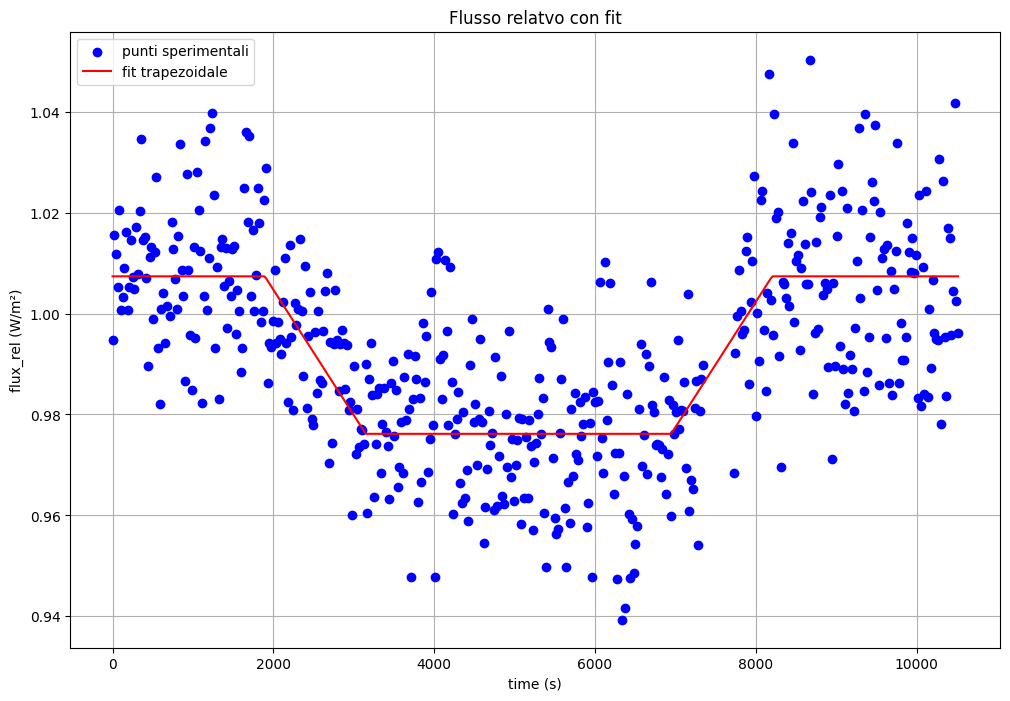

In [16]:
Ft1 = piecewise(np.array(time), *params1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid()
ax.set_axisbelow(True)
ax.scatter(time, flux, c='b', label='punti sperimentali')
ax.plot(time, Ft1, c='r', label='fit trapezoidale')
ax.set_title('Flusso relatvo con fit')
ax.set_xlabel('time (s)')
ax.set_ylabel('flux_rel (W/m²)')
ax.legend(loc='upper left')
plt.show()

Procediamo dunque alla stima degli errori sulle $y$ come residui:

$\varepsilon_i = y_i - \hat{y}_i$

$\displaystyle \widehat{\sigma^2} = \frac{1}{N - D} \left \langle \varepsilon^2 \right \rangle$, con $N$ le misure e $D$ il numero di parametri determinati dal fit; $N - D = k$ gradi di libertà.

$\left \langle \varepsilon^2 \right \rangle = \sum_i \varepsilon_i^2$, non abbiamo bisogno dei pesi $w_i$ perché consideriamo tutti i $\sigma_i$ uguali tra loro.

Calcoliamo anche la media dei residui, aspettandoci che sia sufficientemente vicina a 0.

In [17]:
res = flux - Ft1
N, D = len(flux), len(params1)
k = N - D
sigmafluxhat = np.std(res, ddof=D)
print(f'sigma_flux_hat = {sigmafluxhat:.5e}')
print(f'media dei residui = {np.mean(res):.5e}')

sigma_flux_hat = 1.44660e-02
media dei residui = -5.92833e-05


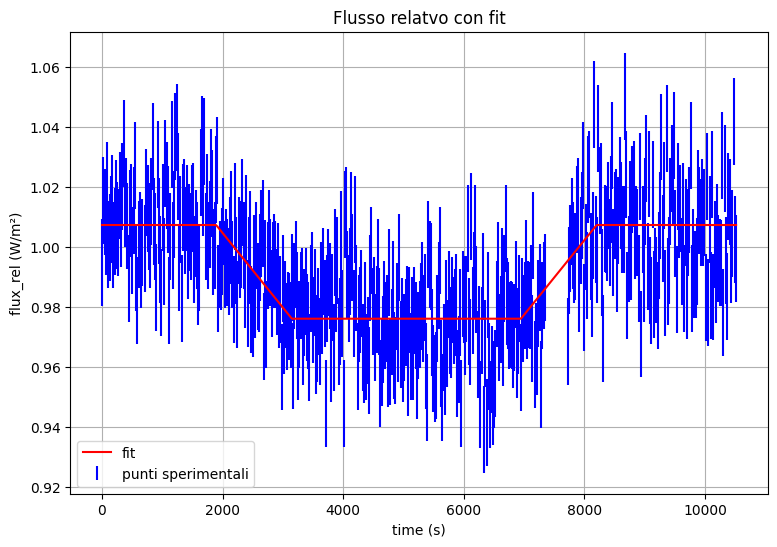

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.grid()
ax.set_axisbelow(True)
ax.errorbar(time, flux, yerr=sigmafluxhat, c='b', linestyle='', label='punti sperimentali')
ax.plot(time, Ft1, c='r', label='fit')
ax.set_title('Flusso relatvo con fit')
ax.set_xlabel('time (s)')
ax.set_ylabel('flux_rel (W/m²)')
ax.legend(loc='lower left')
plt.show()

Il fit segue bene i dati, ma con una leggera sovrastima nella regione centrale.

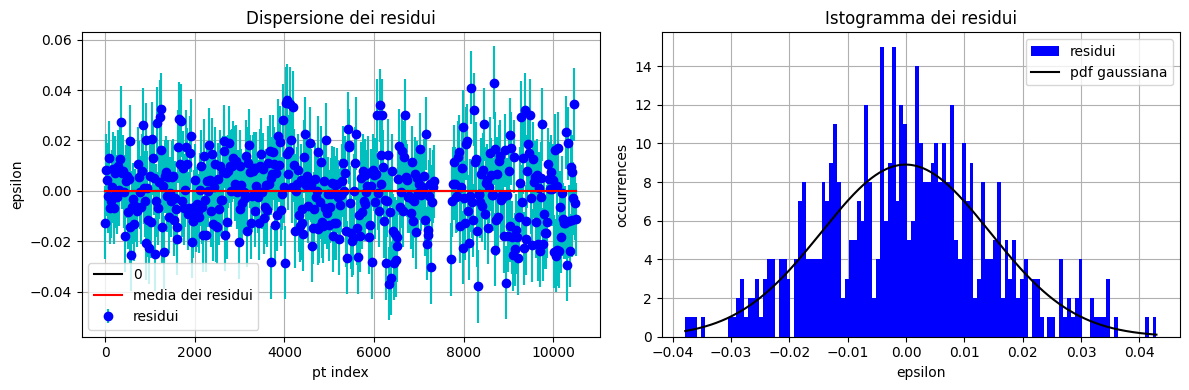

In [57]:
nbins = 121
x = np.linspace(min(res), max(res), 5000)
bin_width = (max(res) - min(res))/nbins

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.grid()
ax1.set_axisbelow(True)
ax1.errorbar(time, res, yerr=sigmafluxhat, ecolor='c', c='b', fmt='o', label='residui', zorder=2)
ax1.plot(time, np.zeros(np.shape(time)[0]), c='k', label='0', zorder=3)
ax1.plot(time, np.full(np.shape(time)[0], np.mean(res)), c='r', label='media dei residui', zorder=4)
ax1.set_title('Dispersione dei residui')
ax1.set_xlabel('pt index')
ax1.set_ylabel('epsilon')
ax1.legend(loc='lower left')

ax2.grid()
ax2.set_axisbelow(True)
ax2.hist(res, bins=nbins, color='b', label='residui')
ax2.plot(x, stats.norm.pdf(x, loc=np.mean(res), scale=sigmafluxhat)*len(res)*bin_width, c='0', label='pdf gaussiana')
ax2.set_title('Istogramma dei residui')
ax2.set_xlabel('epsilon')
ax2.set_ylabel('occurrences')
ax2.legend()

plt.tight_layout()
plt.show()

Osservando la dispersione dei residui, come ci aspettavamo appaiono ben disposti e simmetrici rispetto allo zero. Dall'istogramma però appaiono un po' più concentrati attorno al valor medio rispetto che ad una gaussiana standard.

### Fit con modello trapezoidale: seconda iterazione

Possiamo chiederci se fare una seconda iterazione del fit, usando come *first guesses* i parametri precedentemente determinati, possa portare a una riduzione degli errori.

In [74]:
lsquaresflux2 = LeastSquares(time, flux, sigmafluxhat, piecewise)
mF2 = Minuit(lsquaresflux, *params1)
mF2.fixed['F0'] = True
mF2.migrad()
mF2.hesse()

params2 = np.array([*mF2.values])
err2 = np.array([*mF2.errors])

for i in range(len(params1)):
    print(f'{mF2.parameters[i]}:\n old = {params1[i]:.5f} +- {err1[i]:.5f}\n new = {params2[i]:.5f} +- {err2[i]:.5f}\n')

F0:
 old = 1.00737 +- 0.07173
 new = 1.00737 +- 0.01007

deltaF:
 old = 0.03120 +- 0.10371
 new = 0.03117 +- 0.07453

t0:
 old = 5048.04965 +- 3976.28706
 new = 5060.94421 +- 4074.52417

T:
 old = 6309.96280 +- 17276.93112
 new = 6324.53082 +- 14763.29570

tau:
 old = 1255.82311 +- 14350.70841
 new = 1275.40568 +- 12966.26362



In [75]:
Ft2 = piecewise(np.array(time), *params2)
res2 = flux - Ft2
sigmafluxhat2 = np.std(res2, ddof=D)
print(f'sigma_flux_hat:\n old = {sigmafluxhat:.5e}\n new = {sigmafluxhat2:.5e}')
print(f'media dei residui:\n old = {np.mean(res):.5e}\n new = {np.mean(res2):.5e}')

sigma_flux_hat:
 old = 1.44660e-02
 new = 1.44637e-02
media dei residui:
 old = -5.92833e-05
 new = -9.88684e-05


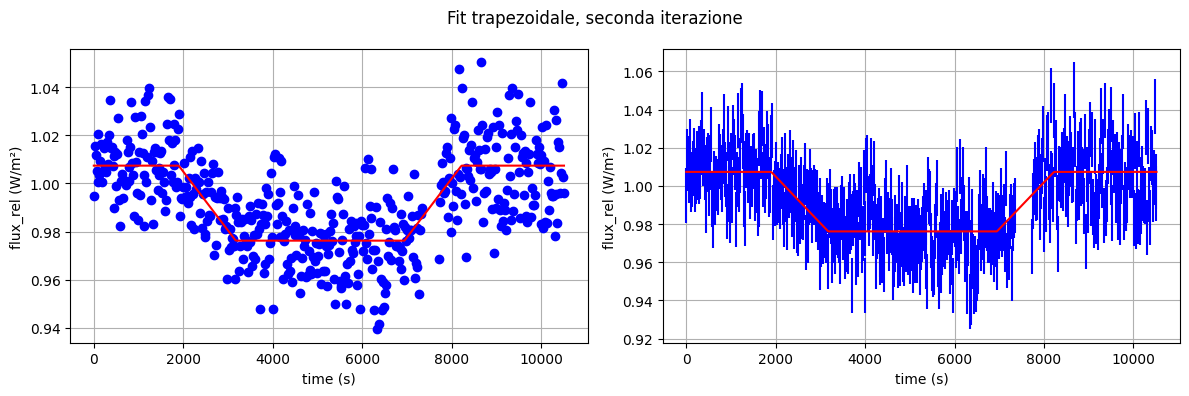

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax1.grid()
ax1.set_axisbelow(True)
ax1.scatter(time, flux, c='b')
ax1.plot(time, Ft2, c='r')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('flux_rel (W/m²)')

ax2.grid()
ax2.set_axisbelow(True)
ax2.errorbar(time, flux, yerr=sigmafluxhat2, c='b', linestyle='')
ax2.plot(time, Ft2, c='r')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('flux_rel (W/m²)')

fig.suptitle('Fit trapezoidale, seconda iterazione')
plt.tight_layout()
plt.show()

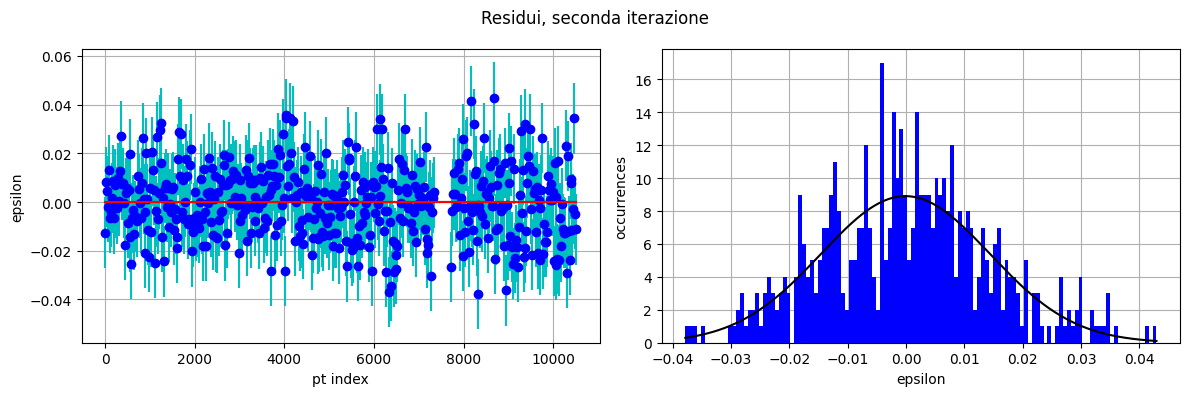

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax1.grid()
ax1.set_axisbelow(True)
ax1.errorbar(time, res2, yerr=sigmafluxhat2, ecolor='c', c='b', fmt='o', zorder=2)
ax1.plot(time, np.zeros(np.shape(time)[0]), c='k', label='0', zorder=3)
ax1.plot(time, np.full(np.shape(time)[0], np.mean(res2)), c='r', zorder=4)
ax1.set_xlabel('pt index')
ax1.set_ylabel('epsilon')

ax2.grid()
ax2.set_axisbelow(True)
ax2.hist(res2, bins=nbins, color='b')
ax2.plot(x, stats.norm.pdf(x, loc=np.mean(res2), scale=sigmafluxhat2)*len(res2)*bin_width, c='0')
ax2.set_xlabel('epsilon')
ax2.set_ylabel('occurrences')

fig.suptitle('Residui, seconda iterazione')
plt.tight_layout()
plt.show()

Non c'è un miglioramento netto degli errori, e lo spostamento dei residui è anzi leggermente più evidente, pertanto ritorniamo ad usare i dati della prima iterazione.

In [26]:
F0, deltaF, t0, T, tau = params1

## Stima della raggio del pianeta

Possiamo adesso fare una stima del raggio del pianeta $R_p$, usando i dati noti della stella $R_\star, F_\star$ e i parametri ricavati dal *fit*. Ricavato il raggio, possiamo costruire un modello più accurato facendo uso di un pacchetto apposito.

* $k = R_p / R_\star$
* $\delta F = (F_0 - F_1)/F_0 = \Delta F / F_0$
* $F_p / F_\star = k^2 I_p/I_\star$, dove $I_p, I_\star$ sono le intensità mediate sulla superficie
* $\delta F \approx k^2 (1 - I_p/I_\star) \approx k^2$ perché durante il transito supponiamo che $I_p \approx 0$ perché il pianeta non è illuminato
* $R_p \approx R_\star \sqrt{\delta F}$

Il risultato è in unità di raggi solari.

In [27]:
Rstar =  0.805
Rstarerr = 0.016

Rjupiter = 9.955

F0err = err1[0]
deltaFerr = err1[1]

deltaF_norm = deltaF/F0
deltaF_normerr = F0err*(deltaF/(F0**2)) + deltaFerr*(1/F0)

Rp = Rstar*np.sqrt(deltaF_norm)*Rjupiter
Rperr = (deltaF_normerr*Rstar/(2*np.sqrt(deltaF_norm)) + Rstarerr*np.sqrt(deltaF_norm))*Rjupiter

print(f'raggio pianeta = {Rp:.3f} +- {Rperr:.3f}')
print(f'raggio nominale = {1.138} +- {0.077}')

raggio pianeta: 1.410 +- 2.422
raggio nominale: 1.138 +- 0.077


C'è una sovrastima del raggio, quindi anche $\delta F$ è sovrastimato; difficile dire se però è $F_0$ ad essere troppo piccolo, o $F_1$ troppo grande.

## Stima del semiasse maggiore

Anche questo parametro va stimato per andare poi a costruire un modello successivo.

* $\displaystyle \frac{a}{R_\star} = \frac{2 \delta F^{1/4}}{\sqrt{\sin^2\left(\frac{\pi T}{P}\right) - \sin^2\left(\frac{\pi (T - 2\tau)}{P}\right)}}$
* $\displaystyle a = R_\star \frac{2 \delta F^{1/4}}{\sqrt{\sin^2\left(\frac{\pi T}{P}\right) - \sin^2\left(\frac{\pi (T - 2\tau)}{P}\right)}}$

Come prima, è dato in unità di raggi solari.

In [76]:
P = 2.2185757*86400 #day*s
a = Rstar*(2*deltaF_norm**(1/4))/(np.sqrt(np.sin(np.pi*T/P)**2 - np.sin(np.pi*(T - 2*tau)/P)**2))
anom = 6.6631235509

print(f'semiasse maggiore = {a:.5f}')
print(f'semiasse nominale = {anom:.5f}')

semiasse maggiore = 8.19897
semiasse nominale = 6.66312


In questo caso la sovrastima è ancora più evidente, perché si va a combinare l'effetto dell'incertezza sui vari parametri, peraltro non indipendenti.

## Stima della massa del pianeta

Per completezza, possiamo fare una stima della massa del pianeta, sebbene siano necessarie parecchie approssimazioni.

* $\displaystyle \frac{M_p}{(M_p + M_\star)^{2/3}} = \frac{K_\star \sqrt{1 - e^2}}{\sin i} (\frac{P}{2\pi G})^{1/3}$
* $M_p \ll M_\star \implies M_p + M_\star \approx M_\star$
* L'osservazione del transito degli esopianeti ha un bias intrinseco verso pianeti con un angolo di inclinazione $i$ tale che $\sin i \approx 1$
* L'eccentricità dell'orbita $e$ viene approssimata come $0$
* Il periodo $P$ lo consideriamo come noto, perché richiede osservazioni ripetute per essere stimato
* La semiampiezza della velocità radiale $K$ viene anch'essa ritenuta nota perché richiede analisi ripetute di curve di luce e degli spettri della stella e del sistema
* $ \displaystyle M_p \approx M_\star^{2/3} K (\frac{P}{2\pi G})^{1/3}$

Non vi sono dati sugli errori di alcune grandezze. I risultati sono in unità di masse solari.

In [73]:
Mstar = 0.8
Mstarerr = 0.4

Mjupiter = 9.547919*(10**(-4))

K = 0.205 #km/s
G = 1.32712440021*(10**(11)) #km^3 Msun^(-1) s^(-2)

Mp = Mstar**(2/3)*K*((P/(2*np.pi*G))**(1/3))/Mjupiter

print(f'massa pianeta = {Mp:.3f}')
print(f'massa nominale = {1.138}')

massa pianeta = 1.133
massa nominale = 1.138


## Limb Darkening

Passiamo ora ad implementare un modello più sofisticato, facendo uso del pacchetto `batman`, il quale, dati dei parametri, simula una curva di luce.

In particolare quello viene implementato è il **limb darkening**, cioè il fenomeno per cui l'intensitá luminosa di una stella $I_\star$ diminuisce con l'allontanarsi dal centro della stessa. Il meccanismo con cui avviene questo fenomeno è complesso e ciò ne rende difficile la modellizzazione, nonché fortemente dipendente sia dall'astro osservato, che dalla strumentazione e dalle condizioni di osservazione.

Le cause sono da ricercarsi nella diminuzione di densità e temperatura della stella allontanadosi dal centro. Con una grande semplificazione, possiamo dire che guardando verso una stella, vediamo (una certa frazione di) fotoni che hanno percorso una certa distanza $L$ all'interno della stella prima di raggiungere il bordo; ma quando osserviamo lontano dal centro, a parità di $L$ il fotone arriva da meno in profondità, e quindi da una zona più fredda, che corrisponderà ad una radiazione meno luminosa.

![Limb darkening](limb_darkening.png)
[Exoplanet Diagrams](https://exoplanet-diagrams.blogspot.com)

L'effetto del *limb darkening* sulla curva di luce è una diminuzione del flusso $\delta F$ durante il transito maggiore di $k^2$ verso il centro della stella, e minore vicino al bordo. Il nostro modello quindi dovrebbe avere un picco più profondo e arrotondato anziché costante, e nessuna discontinuità nei punti di contatto.

Nella pratica, anziché considerare $I_\star$ costante, si considera $I_\star = I_\star (X, Y; u)$, dove $X,Y$ sono le coordinate del pianeta nel sistema di riferimento con l'origine sul centro del disco stellare. Vi sono diverse funzioni che modellizzano questo effetto; generalmente si usa una funzione con due parametri $u_1, u_2$. La formula più comune è una relazione quadratica del tipo $I_\star \propto 1 - u_1(1 - \mu) - u_2(1 - \mu)^2$, con $\mu = \sqrt{1 - X^2 - Y^2}$

![Limb darkening effect](limb_dark_light_curves.jpg)
[SciTechDaily](https://scitechdaily.com/how-stellar-magnetism-is-reshaping-our-view-of-distant-worlds/)

Per i parametri $u_1, u_2$ esistono valori tabulati, poiché dipendono da particolari caratteristiche della stella in questione.

* $T_\text{eff} = 4875\ \text{K}$, temperatura effettiva
* $Z = -0.03$ (log[M/H]), metallicità
* $\log \text{g} = 4.54$, gravità superficiale
* $\xi = 2.0\ \text{km/s}$, velocità delle microturbolenze per la stella

È inoltre necessario specificare quali filtri sono stati usati durante l'osservazione; dato che nel nostro caso non ne sono stati usati, assumiamo un generico filtro V (visibile).

I coefficienti sono stati presi dal database [VizieR](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af)

Il pacchetto `batman` che andiamo a utilizzare, oltre ai due coefficienti sopra, richiede una serie di parametri specifici del transito. $t_0, R_p, a$ li abbiamo stimati prima, e $P$ come detto lo prendiamo tabulato; l'inclinazione orbiale e l'eccentricità dell'orbita nuovamente li consideriamo trascurabili. La longitudine del periastro non è nota, quindi lasciamo il valore di default.

Da notare che `batman` va a considerare il flusso normalizzato $F(t)/F_0$.

In [43]:
u1_quad, u2_quad = 0.7575, 0.0534

paramsB = batman.TransitParams()
paramsB.t0 = t0
paramsB.per = P
paramsB.rp = (Rp/Rjupiter)/Rstar
paramsB.a = a/Rstar
paramsB.inc = 90 #inclinazione orbitale (in gradi)
paramsB.ecc = 0 #eccentricità
paramsB.w = 20 #longitudine del periastron (in gradi)
paramsB.u = [u1_quad, u2_quad]
paramsB.limb_dark = 'quadratic' #limb darkening model

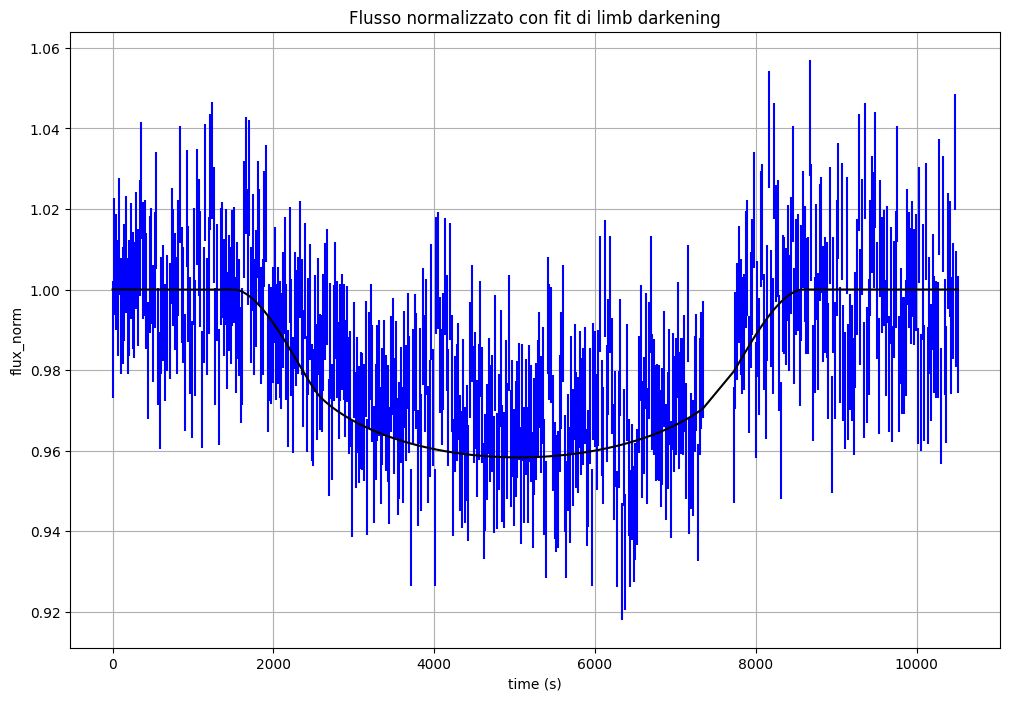

In [45]:
mB = batman.TransitModel(paramsB, np.array(time))
FB = mB.light_curve(paramsB)

fig, ax = plt.subplots(figsize=(12,8))
ax.grid()
ax.set_axisbelow(True)
ax.errorbar(time, flux/F0, yerr=sigmafluxhat, c='b', linestyle='')
ax.plot(time, FB, c='k')
ax.set_xlabel('time (s)')
ax.set_ylabel('flux_norm')
ax.set_title('Flusso normalizzato con fit di limb darkening')
plt.show()

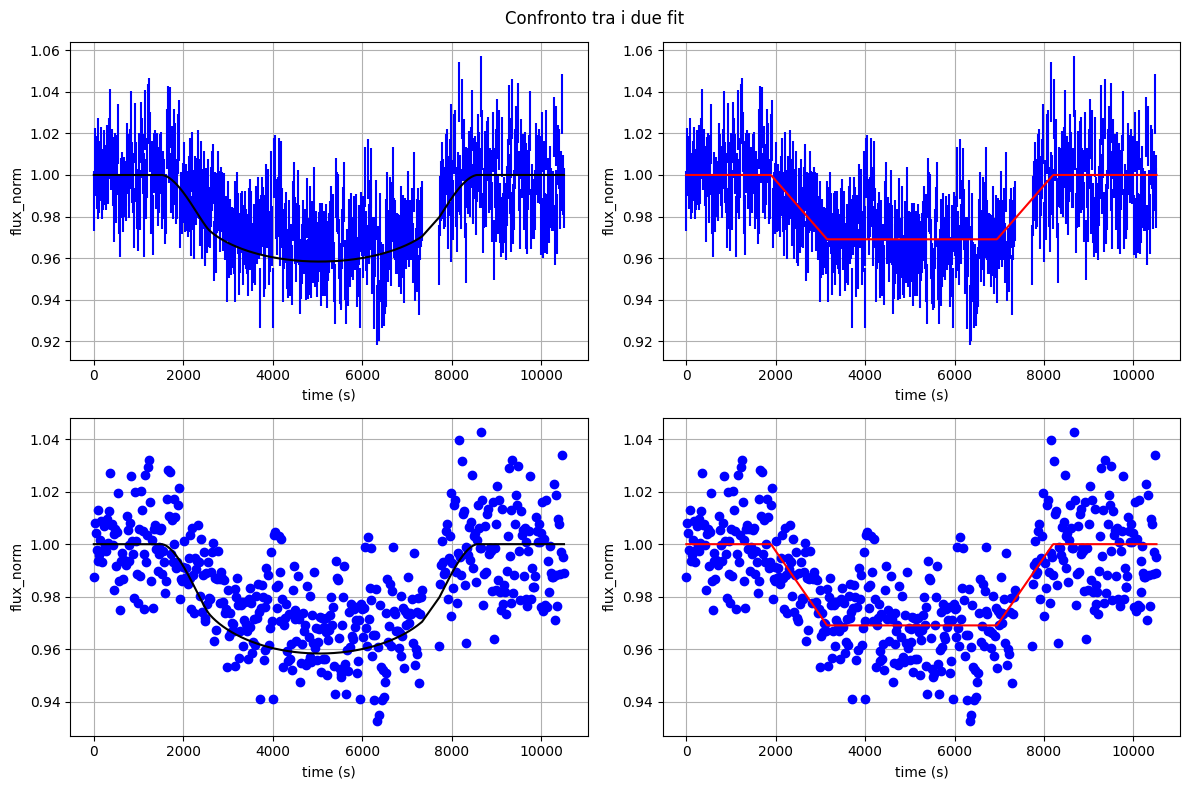

In [49]:
fig, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax1.grid()
ax1.set_axisbelow(True)
ax1.errorbar(time, flux/F0, yerr=sigmafluxhat, c='b', linestyle='')
ax1.plot(time, FB, c='k')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('flux_norm')

ax2.grid()
ax2.set_axisbelow(True)
ax2.errorbar(time, flux/F0, yerr=sigmafluxhat, c='b', linestyle='')
ax2.plot(time, Ft1/F0, c='r')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('flux_norm')

ax3.grid()
ax3.set_axisbelow(True)
ax3.scatter(time, flux/F0, c='b')
ax3.plot(time, FB, c='k')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('flux_norm')

ax4.grid()
ax4.set_axisbelow(True)
ax4.scatter(time, flux/F0, c='b')
ax4.plot(time, Ft1/F0, c='r')
ax4.set_xlabel('time (s)')
ax4.set_ylabel('flux_norm')

fig.suptitle('Confronto tra i due fit')
plt.tight_layout()
plt.show()

In [72]:
resB = flux - FB*F0
sigmafluxhatB = np.std(resB, ddof=D)

print(f'sigma_flux_hat:\n old = {sigmafluxhat:.5e}\n new = {sigmafluxhatB:.5e}')
print(f'media dei residui:\n old = {np.mean(res):.5e}\n new = {np.mean(resB):.5e}')

sigma_flux_hat:
 old = 1.44660e-02
 new = 1.50027e-02
media dei residui:
 old = -5.92833e-05
 new = 4.45498e-03


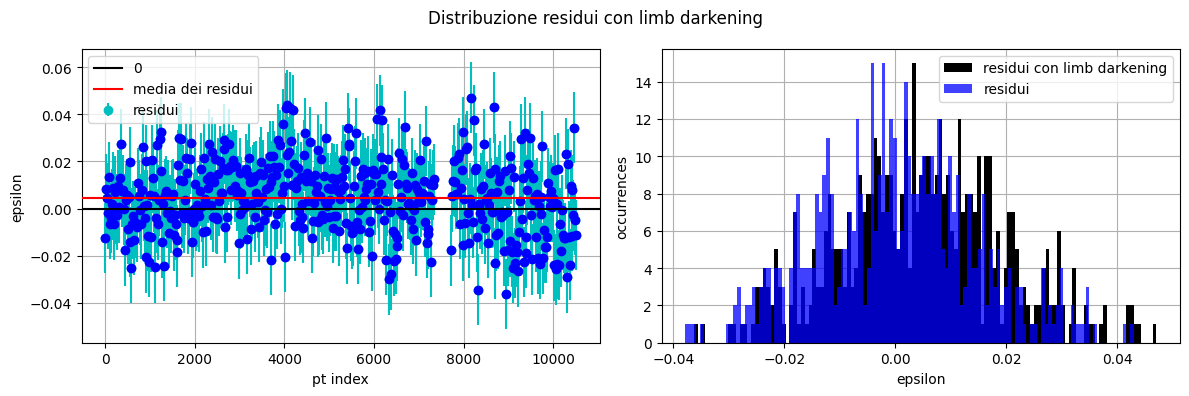

In [126]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.grid()
ax1.set_axisbelow(True)
ax1.errorbar(time, resB, yerr=sigmafluxhatB, c='c', fmt='o', label='residui', zorder=3)
ax1.scatter(time, resB, c='b', zorder=4)
ax1.axhline(0, c='k', label='0', zorder=5)
ax1.axhline(np.mean(resB), c='r', label='media dei residui', zorder=6)
ax1.set_xlabel('pt index')
ax1.set_ylabel('epsilon')
ax1.legend()

ax2.grid()
ax2.set_axisbelow(True)
ax2.hist(resB, bins=nbins, color='k', label='residui con limb darkening')
ax2.hist(res, bins=nbins, color='b', label='residui', alpha=0.75)
ax2.set_xlabel('epsilon')
ax2.set_ylabel('occurrences')
ax2.legend()

fig.suptitle('Distribuzione residui con limb darkening')
plt.tight_layout()
plt.show()

L'aggiunta del *limb darkening* quindi, pur essendo corretta dal punto di vista teorico, fa sì che il *fit* passi dall'essere una sovrastima, ad una sottostima; la media dei residui diventa inoltre significativamente diversa da zero.

Proviamo a vedere se con diversi modelli funzionali la situazione migliora.

In [122]:
u1_sqrt, u2_sqrt = 0.7016, 0.1376
u1_log, u2_log = 0.8208, 0.0554
limb_dark = ['quadratic', 'squareroot', 'logarithmic']
sigmafluxhatBs = np.array([sigmafluxhatB])
meanresBs = np.array([np.mean(resB)])

paramsBsqrt = paramsB
paramsBsqrt.limb_dark = limb_dark[1]
mBsqrt = batman.TransitModel(paramsBsqrt, np.array(time))
FBsqrt = mB.light_curve(paramsBsqrt)
resBsqrt = flux - FBsqrt*F0
sigmafluxhatBsqrt = np.std(resBsqrt, ddof=D)
sigmafluxhatBs = np.append(sigmafluxhatBs, sigmafluxhatBsqrt)
meanresBs = np.append(meanresBs, np.mean(resBsqrt))

paramsBlog = paramsB
paramsBlog.limb_dark = limb_dark[2]
mBlog = batman.TransitModel(paramsBlog, np.array(time))
FBlog = mB.light_curve(paramsBlog)
resBlog = flux - FBlog*F0
sigmafluxhatBlog = np.std(resBlog, ddof=D)
sigmafluxhatBs = np.append(sigmafluxhatBs, sigmafluxhatBlog)
meanresBs = np.append(meanresBs, np.mean(resBlog))

print(f'model: trapezoidal\n sigma_flux = {sigmafluxhat:.5e}, media res = {np.mean(res):.5e}')
for i in range(len(limb_dark)):
    print(f'model: {limb_dark[i]}\n sigma_flux = {sigmafluxhatBs[i]:.5e}, media res = {meanresBs[i]:.5e}')

model: trapezoidal
 sigma_flux = 1.44660e-02, media res = -5.92833e-05
model: quadratic
 sigma_flux = 1.50027e-02, media res = 4.45498e-03
model: squareroot
 sigma_flux = 1.50741e-02, media res = 4.72086e-03
model: logarithmic
 sigma_flux = 1.50027e-02, media res = 4.45496e-03


Cambiare il modello quindi purtroppo non porta a signficativi miglioramenti.

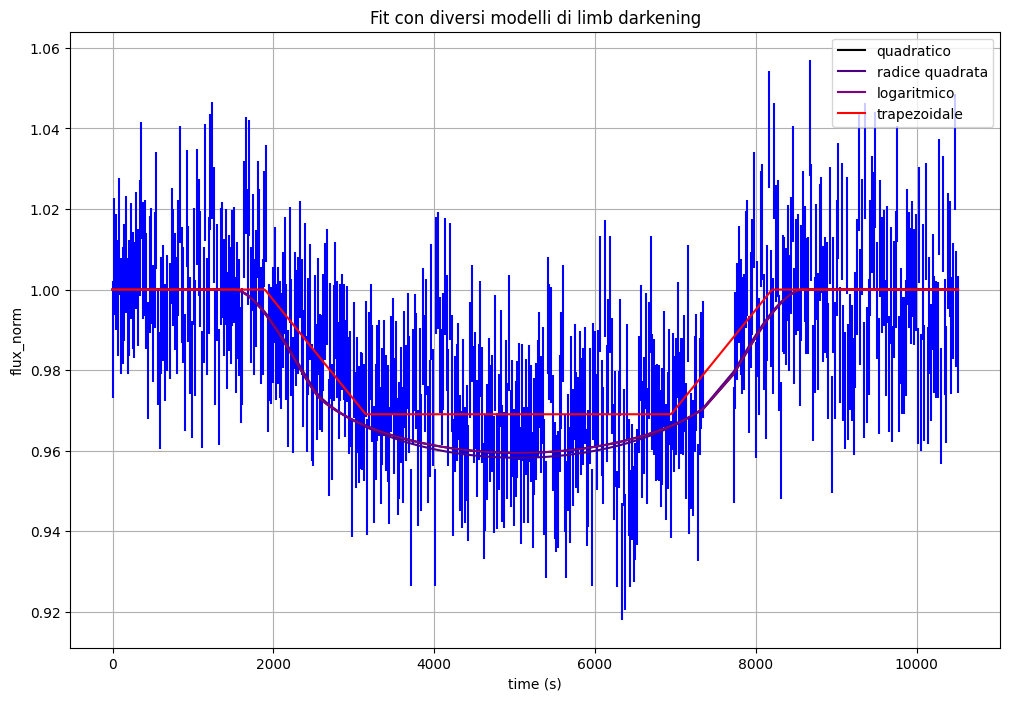

In [120]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.grid()
ax.set_axisbelow(True)
ax.errorbar(time, flux/F0, yerr=sigmafluxhat, c='b', linestyle='')
ax.plot(time, FB, c='k', label='quadratico')
ax.plot(time, FBsqrt, color='indigo', label='radice quadrata')
ax.plot(time, FBlog, color='purple', label='logaritmico')
ax.plot(time, Ft1/F0, c='r', label='trapezoidale')
ax.set_xlabel('time (s)')
ax.set_ylabel('flux_norm')
ax.legend()

plt.title('Fit con diversi modelli di limb darkening')
plt.show()

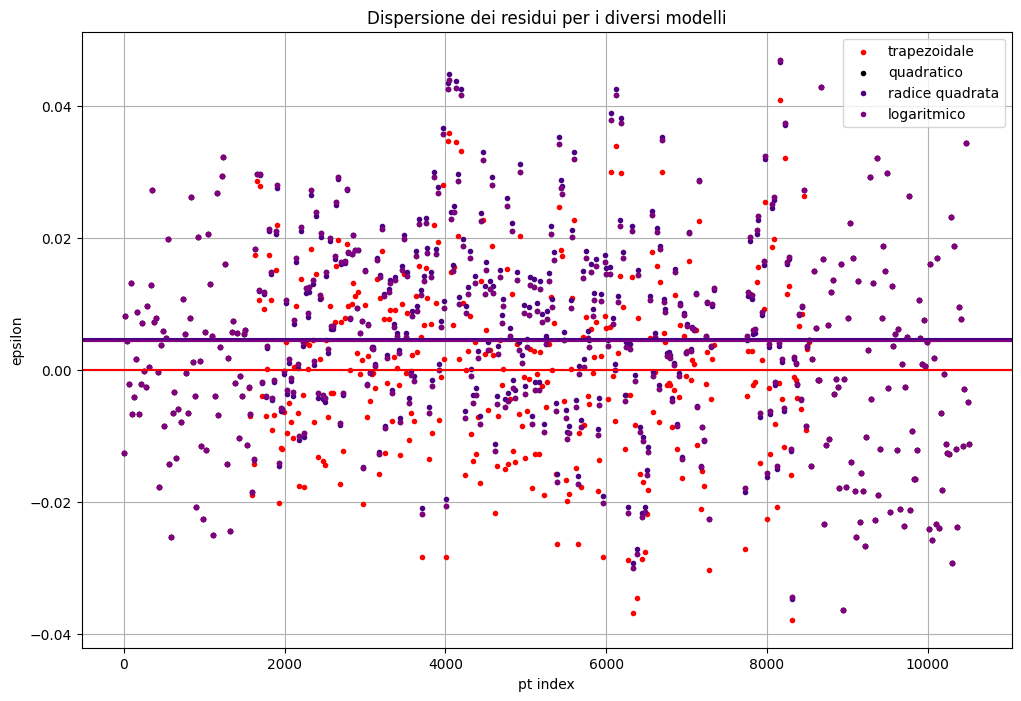

In [127]:
#per motivi grafici gli errori non sono riportati

fig, ax = plt.subplots(figsize=(12, 8))

ax.grid()
ax.set_axisbelow(True)
ax.scatter(time, res, c='r', marker='.', label='trapezoidale')
ax.scatter(time, resB, c='k', marker='.', label='quadratico')
ax.scatter(time, resBsqrt, color='indigo', marker='.', label='radice quadrata')
ax.scatter(time, resBlog, color='purple', marker='.', label='logaritmico')
ax.axhline(0, c='grey')
ax.axhline(np.mean(res), c='r')
ax.axhline(meanresBs[0], c='k')
ax.axhline(meanresBs[1], color='indigo')
ax.axhline(meanresBs[2], color='purple')
ax.set_xlabel('pt index')
ax.set_ylabel('epsilon')
ax.legend()
plt.title('Dispersione dei residui per i diversi modelli')

plt.show()

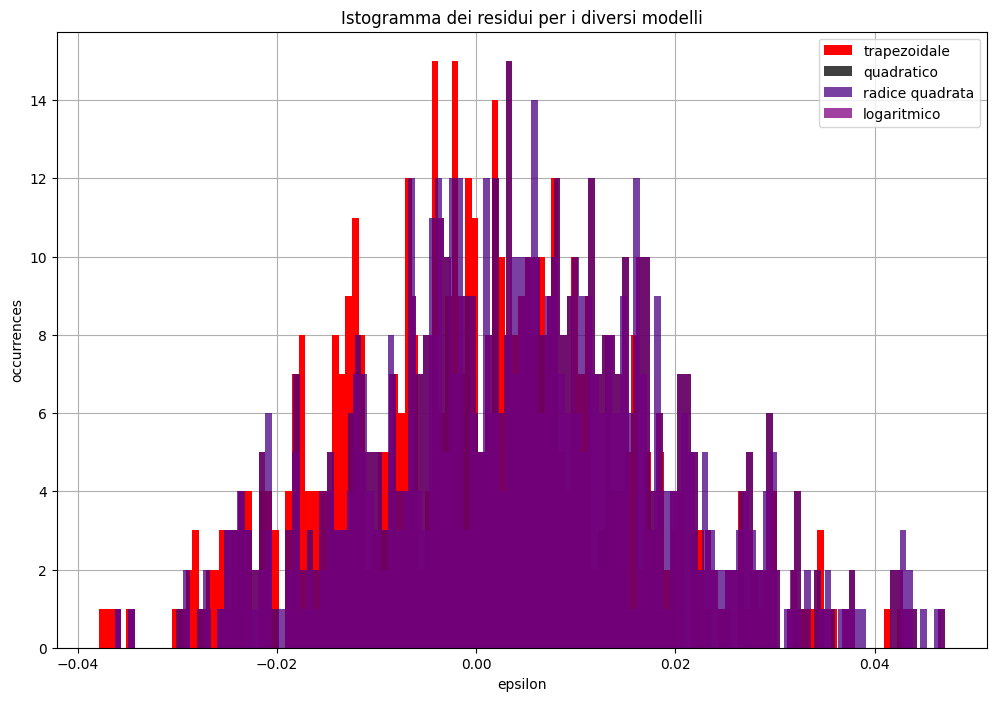

In [130]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.grid()
ax.set_axisbelow(True)
ax.hist(res, bins=nbins, color='r', label='trapezoidale')
ax.hist(resB, bins=nbins, color='k', label='quadratico', alpha=0.75)
ax.hist(resBsqrt, bins=nbins, color='indigo', label='radice quadrata', alpha=0.75)
ax.hist(resBlog, bins=nbins, color='purple', label='logaritmico', alpha=0.75)
ax.set_xlabel('epsilon')
ax.set_ylabel('occurrences')
ax.legend()
plt.title('Istogramma dei residui per i diversi modelli')

plt.show()

## Riduzione errore

Come ultima analisi, possiamo mostrare che se avessimo a disposizione un gran numero di transiti riusciremmo a mitigare l'errore, nonostante le condizioni sperimentali avverse. Questo perché resta valida l'ipotesi di punti sperimentali come variabili gaussiane attorno ad un valor medio.

In [138]:
N = 500 #N transiti
deltaFs = []
paramsMC = dict(F0=params1[0], deltaF=params1[1], t0=params1[2], T=params1[3], tau=params1[4]) #starting params

for i in range(N):
    Fsim = piecewise(np.array(time), **paramsMC) + np.random.normal(0, sigmafluxhat, size=len(time))
    paramsMC0 = [paramsMC['F0'], paramsMC['deltaF'], paramsMC['t0'], paramsMC['T'], paramsMC['tau']] #interating params
    
    lsquaresMC = LeastSquares(time, Fsim, sigmafluxhat, piecewise)
    msim = Minuit(lsquaresMC, *paramsMC0)
    
    msim.limits['F0']   = (0.5, 2.0)
    msim.limits['deltaF'] = (0, 0.5)
    msim.limits['t0']   = (time.min(), time.max())
    msim.limits['T']    = (0, time.max() - time.min())
    msim.limits['tau']  = (0, (time.max() - time.min())/2)

    try:
        msim.migrad()
        if not msim.valid:
            continue

        paramsopt = msim.values #optimal params
        deltaFs.append(paramsopt[1])
                            
    except Exception:
        continue


 combinanzione transiti:
 1 transiti errore su Delta F = 0.00942
 2 transiti errore su Delta F = 0.00666
 5 transiti errore su Delta F = 0.00421
10 transiti errore su Delta F = 0.00298
20 transiti errore su Delta F = 0.00211
50 transiti errore su Delta F = 0.00133


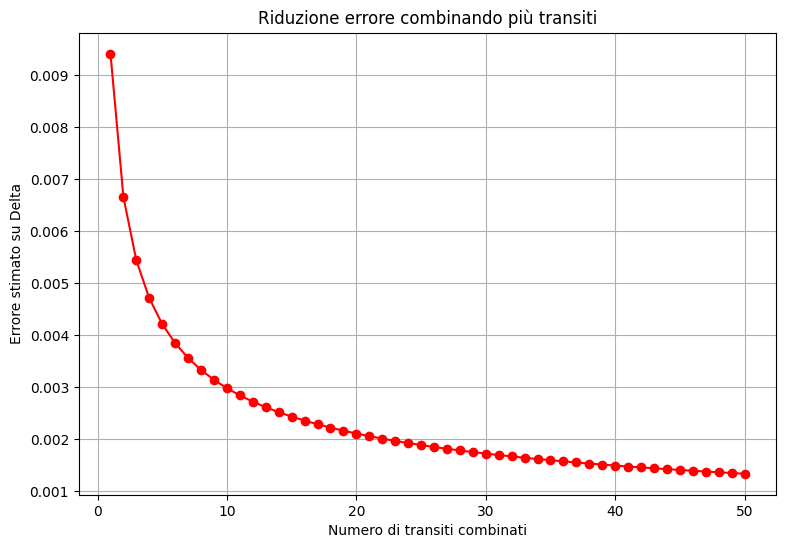

In [142]:
deltaFsmean = np.mean(deltaFs)
stddeltaFs = np.std(deltaFs, ddof=k)

Nstack = np.arange(1, 51)
errstack = stddeltaFs/np.sqrt(Nstack)

fig, ax = plt.subplots(figsize=(9, 6))
ax.grid()
ax.set_axisbelow(True)
ax.plot(Nstack, errstack, '-o', c='r')
ax.set_xlabel('Numero di transiti combinati')
ax.set_ylabel('Errore stimato su Delta')
plt.title('Riduzione errore combinando più transiti')

print("\n combinanzione transiti:")
for n in [1, 2, 5, 10, 20, 50]:
    print(f"{n:2d} transiti errore su Delta F = {stddeltaFs/np.sqrt(n):.5f}")